In [2]:
import os 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Data

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = r"C:\damage-prediction\training\dataset"
dataset = datasets.ImageFolder(root = dataset_path, transform=image_transforms)
len(dataset)

2300

In [28]:
class_names = dataset.classes

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.758*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1743, 557)

In [9]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
labels[0]

tensor(4)

In [13]:
images[0].shape

torch.Size([3, 224, 224])

In [14]:
images[0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9508498..2.1309524].


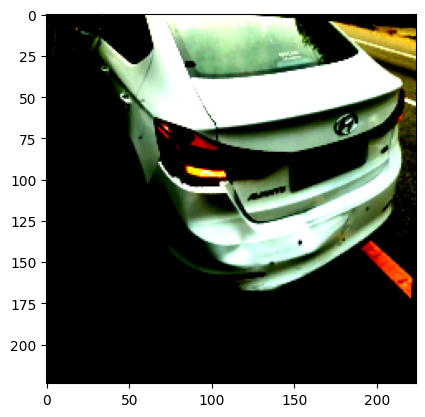

In [15]:
plt.imshow(images[0].permute(1, 2, 0))
plt.show()

## Model 1: CNN

In [16]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #  (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
#Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
#Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
len(train_loader.dataset)

1743

In [19]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            #Zero the parameter gradients
            optimizer.zero_grad()

            #forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss: .4f}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return all_labels, all_predictions
        

In [33]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.68
Batch: 30, Epoch: 1, Loss: 1.78
Batch: 40, Epoch: 1, Loss: 1.81
Batch: 50, Epoch: 1, Loss: 1.79
Epoch [1/5], Avg Loss:  1.7703
*** Validation Accuracy: 22.80% ***
Batch: 10, Epoch: 2, Loss: 1.77
Batch: 20, Epoch: 2, Loss: 1.66
Batch: 30, Epoch: 2, Loss: 1.81
Batch: 40, Epoch: 2, Loss: 1.83
Batch: 50, Epoch: 2, Loss: 1.79
Epoch [2/5], Avg Loss:  1.7700
*** Validation Accuracy: 21.72% ***
Batch: 10, Epoch: 3, Loss: 1.78
Batch: 20, Epoch: 3, Loss: 1.75
Batch: 30, Epoch: 3, Loss: 1.83
Batch: 40, Epoch: 3, Loss: 1.69
Batch: 50, Epoch: 3, Loss: 1.77
Epoch [3/5], Avg Loss:  1.7693
*** Validation Accuracy: 21.72% ***
Batch: 10, Epoch: 4, Loss: 1.77
Batch: 20, Epoch: 4, Loss: 1.76
Batch: 30, Epoch: 4, Loss: 1.78
Batch: 40, Epoch: 4, Loss: 1.75
Batch: 50, Epoch: 4, Loss: 1.77
Epoch [4/5], Avg Loss:  1.7688
*** Validation Accuracy: 22.80% ***
Batch: 10, Epoch: 5, Loss: 1.77
Batch: 20, Epoch: 5, Loss: 1.68
Batch: 30, Epoch: 5, Loss: 1

In [34]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.74
Batch: 20, Epoch: 1, Loss: 1.70
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.74
Batch: 50, Epoch: 1, Loss: 1.77
Epoch [1/10], Avg Loss:  1.7684
*** Validation Accuracy: 21.72% ***
Batch: 10, Epoch: 2, Loss: 1.73
Batch: 20, Epoch: 2, Loss: 1.80
Batch: 30, Epoch: 2, Loss: 1.77
Batch: 40, Epoch: 2, Loss: 1.78
Batch: 50, Epoch: 2, Loss: 1.74
Epoch [2/10], Avg Loss:  1.7675
*** Validation Accuracy: 21.72% ***
Batch: 10, Epoch: 3, Loss: 1.77
Batch: 20, Epoch: 3, Loss: 1.79
Batch: 30, Epoch: 3, Loss: 1.71
Batch: 40, Epoch: 3, Loss: 1.75
Batch: 50, Epoch: 3, Loss: 1.76
Epoch [3/10], Avg Loss:  1.7679
*** Validation Accuracy: 22.80% ***
Batch: 10, Epoch: 4, Loss: 1.73
Batch: 20, Epoch: 4, Loss: 1.74
Batch: 30, Epoch: 4, Loss: 1.77
Batch: 40, Epoch: 4, Loss: 1.80
Batch: 50, Epoch: 4, Loss: 1.75
Epoch [4/10], Avg Loss:  1.7686
*** Validation Accuracy: 21.72% ***
Batch: 10, Epoch: 5, Loss: 1.73
Batch: 20, Epoch: 5, Loss: 1.73
Batch: 30, Epoch: 5, Los

### Model 2: CNN with Regularization

In [20]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #  (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [39]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 58.95
Batch: 20, Epoch: 1, Loss: 2.52
Batch: 30, Epoch: 1, Loss: 2.09
Batch: 40, Epoch: 1, Loss: 1.79
Batch: 50, Epoch: 1, Loss: 1.72
Epoch [1/10], Avg Loss:  52.0514
*** Validation Accuracy: 29.62% ***
Batch: 10, Epoch: 2, Loss: 2.20
Batch: 20, Epoch: 2, Loss: 1.64
Batch: 30, Epoch: 2, Loss: 2.31
Batch: 40, Epoch: 2, Loss: 1.79
Batch: 50, Epoch: 2, Loss: 1.76
Epoch [2/10], Avg Loss:  1.7510
*** Validation Accuracy: 35.73% ***
Batch: 10, Epoch: 3, Loss: 1.76
Batch: 20, Epoch: 3, Loss: 1.79
Batch: 30, Epoch: 3, Loss: 1.72
Batch: 40, Epoch: 3, Loss: 1.82
Batch: 50, Epoch: 3, Loss: 1.71
Epoch [3/10], Avg Loss:  1.7211
*** Validation Accuracy: 35.37% ***
Batch: 10, Epoch: 4, Loss: 1.61
Batch: 20, Epoch: 4, Loss: 1.69
Batch: 30, Epoch: 4, Loss: 1.68
Batch: 40, Epoch: 4, Loss: 1.72
Batch: 50, Epoch: 4, Loss: 1.53
Epoch [4/10], Avg Loss:  1.7021
*** Validation Accuracy: 35.55% ***
Batch: 10, Epoch: 5, Loss: 1.71
Batch: 20, Epoch: 5, Loss: 1.78
Batch: 30, Epoch: 5, L

([5,
  3,
  2,
  5,
  3,
  1,
  1,
  1,
  3,
  2,
  0,
  3,
  0,
  0,
  2,
  4,
  4,
  0,
  5,
  0,
  2,
  0,
  5,
  0,
  1,
  1,
  3,
  5,
  2,
  2,
  3,
  1,
  3,
  0,
  1,
  4,
  2,
  4,
  1,
  2,
  2,
  4,
  5,
  1,
  0,
  0,
  3,
  0,
  2,
  5,
  3,
  2,
  4,
  0,
  2,
  1,
  0,
  4,
  4,
  3,
  4,
  0,
  1,
  0,
  0,
  2,
  3,
  2,
  3,
  0,
  5,
  1,
  1,
  2,
  4,
  5,
  0,
  4,
  1,
  4,
  3,
  4,
  1,
  5,
  0,
  2,
  5,
  1,
  3,
  2,
  0,
  3,
  5,
  2,
  0,
  0,
  1,
  2,
  2,
  4,
  0,
  2,
  0,
  1,
  0,
  5,
  2,
  3,
  0,
  2,
  3,
  1,
  0,
  3,
  4,
  0,
  5,
  3,
  0,
  5,
  1,
  2,
  3,
  3,
  2,
  1,
  3,
  0,
  1,
  4,
  0,
  5,
  4,
  2,
  3,
  2,
  0,
  4,
  5,
  1,
  3,
  0,
  3,
  2,
  2,
  2,
  4,
  1,
  5,
  0,
  1,
  1,
  1,
  2,
  1,
  4,
  1,
  5,
  0,
  2,
  2,
  4,
  1,
  5,
  2,
  5,
  1,
  5,
  0,
  1,
  2,
  3,
  5,
  0,
  5,
  1,
  0,
  1,
  3,
  1,
  4,
  2,
  2,
  3,
  4,
  1,
  0,
  3,
  4,
  0,
  0,
  2,
  4,
  3,
  3,
  2,
  5,
  0,
  2,
  0,


### Model 3: Transfer Learning with EfficientNet

In [40]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\sahit/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:15<00:00, 1.41MB/s]


1280

In [21]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
            
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [42]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.56
Batch: 30, Epoch: 1, Loss: 1.39
Batch: 40, Epoch: 1, Loss: 1.61
Batch: 50, Epoch: 1, Loss: 1.35
Epoch [1/10], Avg Loss:  1.5096
*** Validation Accuracy: 61.04% ***
Batch: 10, Epoch: 2, Loss: 1.15
Batch: 20, Epoch: 2, Loss: 1.16
Batch: 30, Epoch: 2, Loss: 1.02
Batch: 40, Epoch: 2, Loss: 1.03
Batch: 50, Epoch: 2, Loss: 1.19
Epoch [2/10], Avg Loss:  1.1704
*** Validation Accuracy: 63.20% ***
Batch: 10, Epoch: 3, Loss: 0.84
Batch: 20, Epoch: 3, Loss: 1.01
Batch: 30, Epoch: 3, Loss: 1.00
Batch: 40, Epoch: 3, Loss: 0.84
Batch: 50, Epoch: 3, Loss: 1.18
Epoch [3/10], Avg Loss:  1.0344
*** Validation Accuracy: 64.81% ***
Batch: 10, Epoch: 4, Loss: 0.84
Batch: 20, Epoch: 4, Loss: 0.97
Batch: 30, Epoch: 4, Loss: 1.17
Batch: 40, Epoch: 4, Loss: 1.03
Batch: 50, Epoch: 4, Loss: 0.92
Epoch [4/10], Avg Loss:  0.9635
*** Validation Accuracy: 69.30% ***
Batch: 10, Epoch: 5, Loss: 0.89
Batch: 20, Epoch: 5, Loss: 0.86
Batch: 30, Epoch: 5, Los

([2,
  0,
  4,
  2,
  3,
  0,
  0,
  0,
  0,
  2,
  2,
  3,
  0,
  1,
  5,
  4,
  5,
  0,
  1,
  4,
  3,
  1,
  2,
  5,
  2,
  4,
  0,
  3,
  0,
  1,
  5,
  4,
  1,
  2,
  0,
  3,
  0,
  2,
  4,
  2,
  2,
  3,
  0,
  0,
  3,
  0,
  4,
  3,
  1,
  1,
  1,
  2,
  5,
  0,
  0,
  2,
  2,
  2,
  4,
  1,
  4,
  4,
  0,
  2,
  3,
  4,
  0,
  2,
  0,
  3,
  2,
  0,
  1,
  2,
  5,
  1,
  5,
  2,
  1,
  3,
  0,
  5,
  0,
  0,
  5,
  0,
  3,
  0,
  3,
  1,
  5,
  4,
  1,
  2,
  4,
  0,
  2,
  1,
  5,
  1,
  5,
  2,
  5,
  2,
  5,
  0,
  4,
  1,
  4,
  3,
  1,
  1,
  0,
  4,
  4,
  2,
  1,
  0,
  1,
  4,
  2,
  5,
  0,
  4,
  1,
  1,
  3,
  3,
  2,
  0,
  2,
  1,
  0,
  1,
  2,
  1,
  3,
  0,
  2,
  2,
  0,
  1,
  1,
  2,
  0,
  3,
  3,
  0,
  2,
  0,
  0,
  5,
  0,
  0,
  1,
  1,
  0,
  3,
  5,
  2,
  2,
  1,
  1,
  4,
  3,
  2,
  0,
  2,
  1,
  3,
  3,
  5,
  4,
  0,
  2,
  1,
  1,
  5,
  0,
  0,
  3,
  5,
  4,
  3,
  3,
  0,
  0,
  0,
  5,
  2,
  2,
  0,
  1,
  3,
  3,
  2,
  2,
  2,
  1,
  5,


### Model 4: Transfer Learning with ResNet

In [22]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        #Freeze all the layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        #Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        #Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate = 0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.92
Batch: 20, Epoch: 1, Loss: 0.74
Batch: 30, Epoch: 1, Loss: 0.92
Batch: 40, Epoch: 1, Loss: 0.81
Batch: 50, Epoch: 1, Loss: 0.66
Epoch [1/10], Avg Loss:  0.9233
*** Validation Accuracy: 67.32% ***
Batch: 10, Epoch: 2, Loss: 0.36
Batch: 20, Epoch: 2, Loss: 0.60
Batch: 30, Epoch: 2, Loss: 0.76
Batch: 40, Epoch: 2, Loss: 0.57
Batch: 50, Epoch: 2, Loss: 0.35
Epoch [2/10], Avg Loss:  0.5775
*** Validation Accuracy: 76.66% ***
Batch: 10, Epoch: 3, Loss: 0.94
Batch: 20, Epoch: 3, Loss: 0.30
Batch: 30, Epoch: 3, Loss: 0.47
Batch: 40, Epoch: 3, Loss: 0.43
Batch: 50, Epoch: 3, Loss: 0.24
Epoch [3/10], Avg Loss:  0.4027
*** Validation Accuracy: 75.76% ***
Batch: 10, Epoch: 4, Loss: 0.34
Batch: 20, Epoch: 4, Loss: 0.34
Batch: 30, Epoch: 4, Loss: 0.31
Batch: 40, Epoch: 4, Loss: 0.14
Batch: 50, Epoch: 4, Loss: 0.41
Epoch [4/10], Avg Loss:  0.3060
*** Validation Accuracy: 76.84% ***
Batch: 10, Epoch: 5, Loss: 0.30
Batch: 20, Epoch: 5, Loss: 0.29
Batch: 30, Epoch: 5, Los

### Model Evaluation using Confusion matrix and Classification Report

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(labels, predictions)

print(report)

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       102
           1       0.76      0.82      0.79        96
           2       0.94      0.82      0.88       131
           3       0.60      0.85      0.70        81
           4       0.70      0.46      0.55        72
           5       0.90      0.73      0.81        75

    accuracy                           0.79       557
   macro avg       0.79      0.77      0.77       557
weighted avg       0.80      0.79      0.79       557



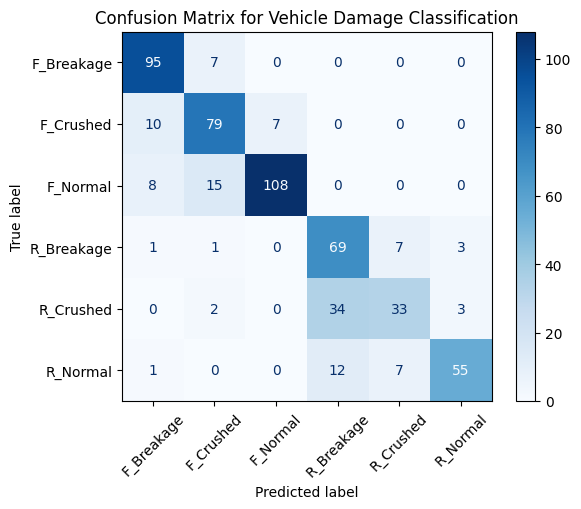

In [29]:
import numpy as np
from sklearn.metrics  import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [30]:
import torch
torch.save(model.state_dict(), 'saved_model.pth')